Simulation of matchgate circuits with matchgate noise:

In [2]:
from matchgates.generators import XY_circuit

n_qubits = 30  # number of qubits
dt = 0.1  # trotter step time interval
J = 0.5  # coupling strength
h = 0.23  # tranverse field
trotter_steps = 20  # number of trotter steps

# generate the XY circuit.
xy = XY_circuit(n_qubits=n_qubits, dt=dt, J=J, h=h, trotter_steps=trotter_steps)

# Avg. gate creation time per layer: 47.14273891644552

Step 1 / 20
Avg. gate creation time per layer: 0.4125730828382075
Step 2 / 20
Avg. gate creation time per layer: 0.25476737483404577
Step 3 / 20
Avg. gate creation time per layer: 0.24104501384620866
Step 4 / 20
Avg. gate creation time per layer: 0.1959427084075287
Step 5 / 20
Avg. gate creation time per layer: 0.1698045667260885
Step 6 / 20
Avg. gate creation time per layer: 0.15091540974875292
Step 7 / 20
Avg. gate creation time per layer: 0.14014994645757334
Step 8 / 20
Avg. gate creation time per layer: 0.14281420840416104
Step 9 / 20
Avg. gate creation time per layer: 0.1562926296869086
Step 10 / 20
Avg. gate creation time per layer: 0.1458862334024161
Step 11 / 20
Avg. gate creation time per layer: 0.13806679933755237
Step 12 / 20
Avg. gate creation time per layer: 0.13151662858823934
Step 13 / 20
Avg. gate creation time per layer: 0.14537191677552003
Step 14 / 20
Avg. gate creation time per layer: 0.14106712506950966
Step 15 / 20
Avg. gate creation time per layer: 0.137193652801

Prepare initial state and observables:

In [3]:
from matchgates import Observable, ProductState

obsz = Observable(name="Z", qubits=[8], n_qubits=n_qubits)
obsyx = Observable(name="YX", qubits=[9, 10], n_qubits=n_qubits)

# prepare initial product state.
initial_state = ProductState.neel(even=True, n_qubits=n_qubits)

To add noise to the circuit, need to make a choice of noise for each gate in the circuit.
If all two qubit gates in the circuit have the same noise model, this noise model
can be set up in a simple way:

In [4]:
from matchgates import SingleGateNoise

p = 0.002
noise_channel = SingleGateNoise.matchgate_depolarizing(p=p)
# matchgate depolarizing is equal probability of perturbation by 
# any matchgate Pauli (Z, ZZ, XY, YX, YY, XX). 

noisy_xy = xy.add_two_qubit_uniform_noise(noise_channel)  # Add noise to circuit.

A noisy circuit can be simulated using the simulate_noisy method.
As the simulation is done by monte-carlo it is necessary to repeat
over some number of repetitions, and this can be distributed over 
multiple jobs. What will be returned is a single dictionary with the 
mean values for all observables in the list, averaged over the
repetitions specified.

In [5]:
from time import perf_counter

# n_jobs = 20
n_jobs = 1
repetitions = 10

start = perf_counter()
results, hash_counts = noisy_xy.simulate_noisy(n_jobs, [obsz, obsyx], repetitions, initial_state)
end = perf_counter()

print("Results for XY circuit with noise:", results)

hash_counts_sorted_by_freq = sorted(list(hash_counts.values()), reverse=True)
trajectories_sorted_by_freq = sorted([(k, v,) for k, v in hash_counts.items()], key=lambda x: x[1], reverse=True)
all_I_string = "I" * len(list(hash_counts.keys())[0])
print("Sorted hash counts:")
print(hash_counts_sorted_by_freq)
print(f"Frequency of all-identity trajectory: {hash_counts[all_I_string]}")
print(f"Most common string: {trajectories_sorted_by_freq[0][0]}")
print(f"with frequency {hash_counts[trajectories_sorted_by_freq[0][0]]}")

print(f"Avg. time per run: {(end - start) / repetitions}s")

Results for XY circuit with noise: {'Z(8,)': np.float32(-0.1935812), 'YX(9, 10)': np.float32(-0.18295512)}
Sorted hash counts:
[2, 1, 1, 1, 1, 1, 1, 1, 1]
Frequency of all-identity trajectory: 0
Most common string: IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

In practice, I find it most convenient to loop the above over a large number of iterations
and after each iterations append the results to a csv file. Then it is possible to access the
data over multiple iterations and compute statistics (mean, std, etc.) to check how well 
converged the results are.

In [8]:
from time import time
import pandas as pd

start_time = time()

iterations = 100

filename = f"./XY_p{p}_N{n_qubits}_J{J}_h{h}_steps{trotter_steps}_rep{repetitions}.csv"

for i in range(iterations):
    results, _ = noisy_xy.simulate_noisy(n_jobs, [obsz, obsyx], repetitions, initial_state)
    new_results = {}
    for key in results.keys():
        new_results[key] = [results[key]]
    df = pd.DataFrame(new_results)
    if i == 0:
        df.to_csv(
            filename,
            mode="w",
            header=True,
            index=False,
        )
    else:
        df.to_csv(
            filename,
            mode="a",
            header=False,
            index=False,
        )
    print("Iteration: ", i)
    print("Time taken is ", time() - start_time)
    start_time = time()

Iteration:  0
Time taken is  3.7534661293029785
Iteration:  1
Time taken is  3.793775796890259
Iteration:  2
Time taken is  3.5788869857788086
Iteration:  3
Time taken is  4.0301361083984375
Iteration:  4
Time taken is  3.8847098350524902
Iteration:  5
Time taken is  3.4836573600769043
Iteration:  6
Time taken is  3.210594892501831
Iteration:  7
Time taken is  3.585714101791382
Iteration:  8
Time taken is  3.0467019081115723
Iteration:  9
Time taken is  3.093965768814087
Iteration:  10
Time taken is  3.594733715057373
Iteration:  11
Time taken is  4.965643644332886
Iteration:  12
Time taken is  4.077386856079102
Iteration:  13
Time taken is  3.6365208625793457
Iteration:  14
Time taken is  3.6420772075653076
Iteration:  15
Time taken is  3.650242805480957
Iteration:  16
Time taken is  3.8245158195495605
Iteration:  17
Time taken is  3.252304792404175
Iteration:  18
Time taken is  3.367687225341797
Iteration:  19
Time taken is  3.111798048019409
Iteration:  20
Time taken is  3.400470018

Using data from file ./XY_p0.002_N30_J0.5_h0.23_steps20_rep10.csv


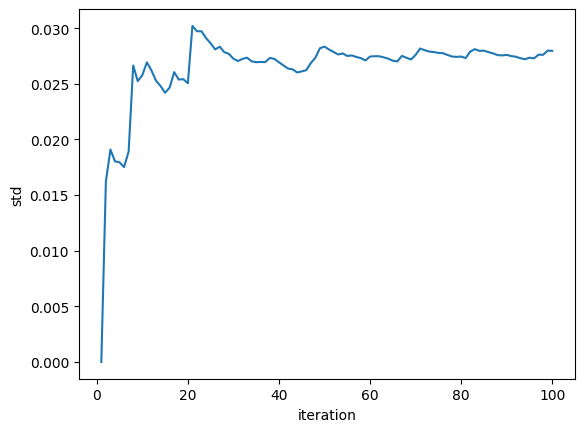

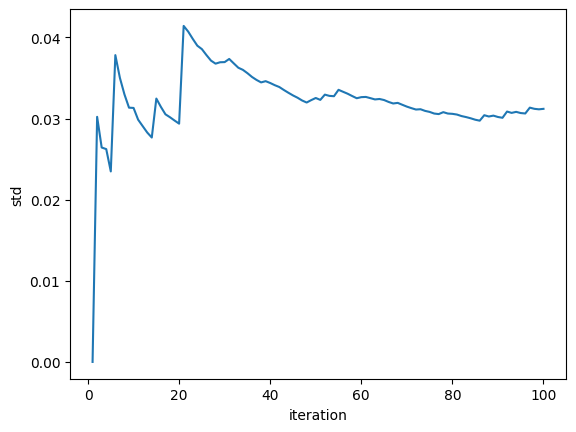

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 


filename = f"./XY_p{p}_N{n_qubits}_J{J}_h{h}_steps{trotter_steps}_rep{repetitions}.csv"
print(f"Using data from file {filename}")

df = pd.read_csv(filename)

for obsv in df:
    obsv_data = df[obsv]
    obsv_data_np = obsv_data.to_numpy()

    X = []
    Y = []
    for i in range(1, len(obsv_data_np) + 1):
        obsv_data_np_truncated = obsv_data_np[:i]
        X.append(i)
        Y.append(np.average(obsv_data_np_truncated))

    # print(f"{obsv}: mean = {np.average(obsv_data_np)}  std = {np.std(obsv_data_np)}")

    plt.plot(X, Y)
    plt.xlabel("iteration")
    plt.ylabel("std")
    plt.show()